<a href="https://colab.research.google.com/github/uday96/EVA4-TSAI/blob/master/S6/EVA4_S6_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
batch_size_cuda = 32
batch_size_cpu = 32

dataloader_args = dict(shuffle=True, batch_size=batch_size_cuda, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_cpu)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([32, 1, 28, 28])
torch.Size([32])


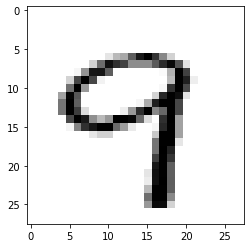

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

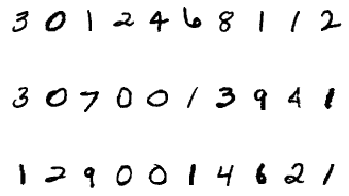

In [6]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(3, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05)
        ) # In: 28x28x1 | Out: 26x26x8 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        ) # In: 26x26x8 | Out: 24x24x10 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x10 | Out: 22x22x12 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | Out: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) # In: 11x11x12 | Out: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        ) # In: 9x9x16 | Out: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # In: 7x7x16 | Out: 5x5x16 | RF: 20

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 5x5x16 | Out: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x16 | Out: 1x1x10 | RF: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,080
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item()} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item()} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)

def test(model, device, test_loader, test_losses, test_acc, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

def run(l1_decay=0.0, l2_decay=0.0):
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  EPOCHS = 40
  test_losses = []
  test_acc = []
  misclassified_imgs = []
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch+1)
      train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay)
      scheduler.step()
      test(model, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
  return test_losses, test_acc, misclassified_imgs

# Let's Train and test our model

### Without L1 and L2 Regularization

In [18]:
# without l1 and l2
test_losses, test_acc, misclassified_imgs = run(l1_decay=0.0, l2_decay=0.0)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.018147200345993042 Batch_id=1874 Accuracy=95.04: 100%|██████████| 1875/1875 [00:30<00:00, 61.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9791/10000 (97.91%)

EPOCH: 2


Loss=0.008050858974456787 Batch_id=1874 Accuracy=98.05: 100%|██████████| 1875/1875 [00:29<00:00, 71.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.006101176142692566 Batch_id=1874 Accuracy=98.51: 100%|██████████| 1875/1875 [00:29<00:00, 63.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.4270470142364502 Batch_id=1874 Accuracy=98.67: 100%|██████████| 1875/1875 [00:30<00:00, 61.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.0397549569606781 Batch_id=1874 Accuracy=98.77: 100%|██████████| 1875/1875 [00:29<00:00, 63.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.11688049137592316 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:29<00:00, 63.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.011846780776977539 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:29<00:00, 64.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 8


Loss=0.017809823155403137 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:29<00:00, 63.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 9


Loss=0.006213203072547913 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:29<00:00, 64.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.009852573275566101 Batch_id=1874 Accuracy=99.28: 100%|██████████| 1875/1875 [00:29<00:00, 64.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.012522950768470764 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:28<00:00, 65.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.0034808218479156494 Batch_id=1874 Accuracy=99.30: 100%|██████████| 1875/1875 [00:28<00:00, 64.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.015625208616256714 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:29<00:00, 63.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.0014372467994689941 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:29<00:00, 63.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.0062207430601119995 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:29<00:00, 64.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.002898603677749634 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:29<00:00, 64.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.0018461644649505615 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:28<00:00, 65.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.00718708336353302 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:28<00:00, 65.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.00032275915145874023 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:28<00:00, 64.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.009809672832489014 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:28<00:00, 64.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.0017158091068267822 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:28<00:00, 66.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.001580744981765747 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:28<00:00, 65.43it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.20930026471614838 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:28<00:00, 65.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.07173517346382141 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:29<00:00, 64.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.0018689930438995361 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:28<00:00, 69.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.0008689165115356445 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:28<00:00, 66.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.001323789358139038 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:28<00:00, 64.86it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 28


Loss=0.011265113949775696 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:28<00:00, 66.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

EPOCH: 29


Loss=0.0012246966361999512 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:28<00:00, 65.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 30


Loss=0.03400304913520813 Batch_id=1874 Accuracy=99.37: 100%|██████████| 1875/1875 [00:29<00:00, 64.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.00535939633846283 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:28<00:00, 64.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.0023094862699508667 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:28<00:00, 65.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


Loss=0.00435309112071991 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:28<00:00, 65.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 34


Loss=0.0038787424564361572 Batch_id=1874 Accuracy=99.40: 100%|██████████| 1875/1875 [00:30<00:00, 62.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

EPOCH: 35


Loss=0.03362026810646057 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:30<00:00, 61.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

EPOCH: 36


Loss=0.004989951848983765 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:31<00:00, 60.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.0896499902009964 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:30<00:00, 60.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 38


Loss=0.013896197080612183 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:30<00:00, 70.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.0006552040576934814 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:31<00:00, 59.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 40


Loss=0.007525980472564697 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:31<00:00, 58.82it/s]



Test set: Average loss: 0.0177, Accuracy: 9941/10000 (99.41%)



### With L1 Regularization

In [24]:
# with l1
test_losses_l1, test_acc_l1, misclassified_imgs_l1 = run(l1_decay=0.00005, l2_decay=0.0)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


L1_loss=665.3253173828125 Loss=0.091722771525383 Batch_id=1874 Accuracy=94.73: 100%|██████████| 1875/1875 [00:35<00:00, 52.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


L1_loss=705.6435546875 Loss=0.10831545293331146 Batch_id=1874 Accuracy=98.09: 100%|██████████| 1875/1875 [00:35<00:00, 52.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


L1_loss=729.3573608398438 Loss=0.16004356741905212 Batch_id=1874 Accuracy=98.37: 100%|██████████| 1875/1875 [00:35<00:00, 52.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


L1_loss=741.0165405273438 Loss=0.13026069104671478 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [00:35<00:00, 52.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


L1_loss=751.1859130859375 Loss=0.05236581712961197 Batch_id=1874 Accuracy=98.60: 100%|██████████| 1875/1875 [00:34<00:00, 53.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


L1_loss=754.9208984375 Loss=0.05031445994973183 Batch_id=1874 Accuracy=98.78: 100%|██████████| 1875/1875 [00:35<00:00, 52.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


L1_loss=746.994873046875 Loss=0.044510092586278915 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:35<00:00, 53.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


L1_loss=740.8943481445312 Loss=0.046137627214193344 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:35<00:00, 57.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

EPOCH: 9


L1_loss=735.3446044921875 Loss=0.03822992742061615 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:35<00:00, 53.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 10


L1_loss=729.8148803710938 Loss=0.03814447298645973 Batch_id=1874 Accuracy=99.28: 100%|██████████| 1875/1875 [00:34<00:00, 53.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


L1_loss=724.5587158203125 Loss=0.04689214378595352 Batch_id=1874 Accuracy=99.26: 100%|██████████| 1875/1875 [00:35<00:00, 63.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH: 12


L1_loss=719.6922607421875 Loss=0.049214668571949005 Batch_id=1874 Accuracy=99.29: 100%|██████████| 1875/1875 [00:35<00:00, 52.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


L1_loss=719.0226440429688 Loss=0.06449180096387863 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:36<00:00, 56.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


L1_loss=718.4054565429688 Loss=0.33416983485221863 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 50.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


L1_loss=717.801513671875 Loss=0.0458272285759449 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:37<00:00, 49.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


L1_loss=717.2012939453125 Loss=0.051223281770944595 Batch_id=1874 Accuracy=99.39: 100%|██████████| 1875/1875 [00:37<00:00, 49.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 17


L1_loss=716.6393432617188 Loss=0.03637785464525223 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:37<00:00, 59.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


L1_loss=716.0536499023438 Loss=0.04063335433602333 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:37<00:00, 49.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


L1_loss=715.9912109375 Loss=0.048918258398771286 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:37<00:00, 49.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 20


L1_loss=715.9296875 Loss=0.03894633427262306 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:37<00:00, 49.65it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9950/10000 (99.50%)

EPOCH: 21


L1_loss=715.8665161132812 Loss=0.03884973004460335 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:37<00:00, 50.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


L1_loss=715.8088989257812 Loss=0.03927004337310791 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:37<00:00, 50.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 23


L1_loss=715.748291015625 Loss=0.06753294169902802 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:37<00:00, 50.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


L1_loss=715.690185546875 Loss=0.03752332553267479 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:37<00:00, 50.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


L1_loss=715.6837768554688 Loss=0.03851074352860451 Batch_id=1874 Accuracy=99.38: 100%|██████████| 1875/1875 [00:37<00:00, 50.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 26


L1_loss=715.6773071289062 Loss=0.045619942247867584 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:36<00:00, 50.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 27


L1_loss=715.6712036132812 Loss=0.08571034669876099 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9949/10000 (99.49%)

EPOCH: 28


L1_loss=715.66455078125 Loss=0.040977489203214645 Batch_id=1874 Accuracy=99.37: 100%|██████████| 1875/1875 [00:36<00:00, 51.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.48%)

EPOCH: 29


L1_loss=715.6581420898438 Loss=0.04233888164162636 Batch_id=1874 Accuracy=99.37: 100%|██████████| 1875/1875 [00:35<00:00, 52.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


L1_loss=715.652099609375 Loss=0.03941717743873596 Batch_id=1874 Accuracy=99.39: 100%|██████████| 1875/1875 [00:36<00:00, 51.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


L1_loss=715.6517333984375 Loss=0.248586505651474 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:35<00:00, 52.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 32


L1_loss=715.6514892578125 Loss=0.1095811277627945 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 51.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)

EPOCH: 33


L1_loss=715.651123046875 Loss=0.03882617875933647 Batch_id=1874 Accuracy=99.37: 100%|██████████| 1875/1875 [00:35<00:00, 61.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


L1_loss=715.6507568359375 Loss=0.04154839366674423 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


L1_loss=715.650390625 Loss=0.08991648256778717 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:37<00:00, 50.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 36


L1_loss=715.6500244140625 Loss=0.053007692098617554 Batch_id=1874 Accuracy=99.39: 100%|██████████| 1875/1875 [00:37<00:00, 50.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


L1_loss=715.6500244140625 Loss=0.05284419655799866 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:37<00:00, 50.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)

EPOCH: 38


L1_loss=715.6500244140625 Loss=0.05941833555698395 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:37<00:00, 61.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


L1_loss=715.6500244140625 Loss=0.039769113063812256 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:36<00:00, 59.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9948/10000 (99.48%)

EPOCH: 40


L1_loss=715.6500244140625 Loss=0.03857196867465973 Batch_id=1874 Accuracy=99.40: 100%|██████████| 1875/1875 [00:36<00:00, 51.57it/s]



Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)



### With L2 Regularization

In [21]:
# with l2
test_losses_l2, test_acc_l2, misclassified_imgs_l2 = run(l1_decay=0.0, l2_decay=0.0003)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=49.1786003112793 Loss=0.026222869753837585 Batch_id=1874 Accuracy=95.14: 100%|██████████| 1875/1875 [00:36<00:00, 51.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


L2_loss=52.96567153930664 Loss=0.09829762578010559 Batch_id=1874 Accuracy=98.04: 100%|██████████| 1875/1875 [00:37<00:00, 49.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


L2_loss=55.15946578979492 Loss=0.028658386319875717 Batch_id=1874 Accuracy=98.50: 100%|██████████| 1875/1875 [00:35<00:00, 57.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


L2_loss=56.66011047363281 Loss=0.01981402561068535 Batch_id=1874 Accuracy=98.61: 100%|██████████| 1875/1875 [00:35<00:00, 57.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


L2_loss=57.89801025390625 Loss=0.10434433817863464 Batch_id=1874 Accuracy=98.74: 100%|██████████| 1875/1875 [00:36<00:00, 51.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


L2_loss=58.84626770019531 Loss=0.03485122323036194 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:36<00:00, 52.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


L2_loss=58.79655075073242 Loss=0.03513874113559723 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:36<00:00, 52.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


L2_loss=58.76115798950195 Loss=0.02495386265218258 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:35<00:00, 52.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


L2_loss=58.732521057128906 Loss=0.020020363852381706 Batch_id=1874 Accuracy=99.28: 100%|██████████| 1875/1875 [00:36<00:00, 51.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


L2_loss=58.69158935546875 Loss=0.08098162710666656 Batch_id=1874 Accuracy=99.30: 100%|██████████| 1875/1875 [00:36<00:00, 51.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 11


L2_loss=58.64910888671875 Loss=0.020413855090737343 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:36<00:00, 51.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


L2_loss=58.6193733215332 Loss=0.053605809807777405 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


L2_loss=58.612884521484375 Loss=0.018435407429933548 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 58.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 14


L2_loss=58.60696029663086 Loss=0.018324434757232666 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


L2_loss=58.60224914550781 Loss=0.039449542760849 Batch_id=1874 Accuracy=99.30: 100%|██████████| 1875/1875 [00:36<00:00, 51.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


L2_loss=58.5982666015625 Loss=0.05822135508060455 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:35<00:00, 52.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 17


L2_loss=58.59370422363281 Loss=0.10436020791530609 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:35<00:00, 52.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9949/10000 (99.49%)

EPOCH: 18


L2_loss=58.588138580322266 Loss=0.021787064149975777 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 51.99it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


L2_loss=58.58760452270508 Loss=0.019075756892561913 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:35<00:00, 53.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9951/10000 (99.51%)

EPOCH: 20


L2_loss=58.58713150024414 Loss=0.16075335443019867 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:35<00:00, 52.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 21


L2_loss=58.58663558959961 Loss=0.0190915297716856 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:35<00:00, 52.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9952/10000 (99.52%)

EPOCH: 22


L2_loss=58.58621597290039 Loss=0.0247503574937582 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:36<00:00, 51.69it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


L2_loss=58.585758209228516 Loss=0.018831150606274605 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.26it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


L2_loss=58.58531951904297 Loss=0.02818276546895504 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

EPOCH: 25


L2_loss=58.585243225097656 Loss=0.041955139487981796 Batch_id=1874 Accuracy=99.28: 100%|██████████| 1875/1875 [00:36<00:00, 51.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)

EPOCH: 26


L2_loss=58.585174560546875 Loss=0.024255191907286644 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:35<00:00, 52.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9953/10000 (99.53%)

EPOCH: 27


L2_loss=58.58511734008789 Loss=0.03472425416111946 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9951/10000 (99.51%)

EPOCH: 28


L2_loss=58.585060119628906 Loss=0.01787699945271015 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:36<00:00, 51.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

EPOCH: 29


L2_loss=58.584983825683594 Loss=0.018073314800858498 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:35<00:00, 52.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 30


L2_loss=58.584922790527344 Loss=0.059345923364162445 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:36<00:00, 51.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 31


L2_loss=58.584922790527344 Loss=0.02591102384030819 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:35<00:00, 52.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


L2_loss=58.584922790527344 Loss=0.018721019849181175 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 55.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 33


L2_loss=58.584922790527344 Loss=0.029859667643904686 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:35<00:00, 52.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 34


L2_loss=58.584922790527344 Loss=0.03252113610506058 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:36<00:00, 51.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


L2_loss=58.584922790527344 Loss=0.021366169676184654 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9950/10000 (99.50%)

EPOCH: 36


L2_loss=58.584922790527344 Loss=0.019639765843749046 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

EPOCH: 37


L2_loss=58.584922790527344 Loss=0.0365806445479393 Batch_id=1874 Accuracy=99.37: 100%|██████████| 1875/1875 [00:36<00:00, 51.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9951/10000 (99.51%)

EPOCH: 38


L2_loss=58.584922790527344 Loss=0.10579847544431686 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 51.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

EPOCH: 39


L2_loss=58.584922790527344 Loss=0.019675707444548607 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:36<00:00, 51.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

EPOCH: 40


L2_loss=58.584922790527344 Loss=0.02032282017171383 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.66it/s]



Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)



### With L1 and L2 Regularization

In [23]:
# with l1 and l2
test_losses_l12, test_acc_l12, misclassified_imgs_l12 = run(l1_decay=0.00005, l2_decay=0.0003)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=48.2072868347168 L1_loss=676.68359375 Loss=0.07056218385696411 Batch_id=1874 Accuracy=94.36: 100%|██████████| 1875/1875 [00:41<00:00, 45.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


L2_loss=50.93183517456055 L1_loss=717.1944580078125 Loss=0.06079971045255661 Batch_id=1874 Accuracy=98.00: 100%|██████████| 1875/1875 [00:43<00:00, 49.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


L2_loss=51.948455810546875 L1_loss=728.2352294921875 Loss=0.05958149582147598 Batch_id=1874 Accuracy=98.42: 100%|██████████| 1875/1875 [00:39<00:00, 55.31it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


L2_loss=52.82865905761719 L1_loss=745.1096801757812 Loss=0.05605519935488701 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:39<00:00, 47.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


L2_loss=53.336280822753906 L1_loss=748.6734008789062 Loss=0.07247766852378845 Batch_id=1874 Accuracy=98.60: 100%|██████████| 1875/1875 [00:39<00:00, 46.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


L2_loss=53.59343338012695 L1_loss=749.1587524414062 Loss=0.07657191157341003 Batch_id=1874 Accuracy=98.72: 100%|██████████| 1875/1875 [00:39<00:00, 47.46it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


L2_loss=53.371849060058594 L1_loss=741.3609619140625 Loss=0.16167865693569183 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:40<00:00, 53.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


L2_loss=53.165218353271484 L1_loss=734.1514892578125 Loss=0.06062878295779228 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:39<00:00, 47.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


L2_loss=52.9564208984375 L1_loss=727.2251586914062 Loss=0.06618242710828781 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:39<00:00, 47.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


L2_loss=52.75934600830078 L1_loss=720.4532470703125 Loss=0.06619834899902344 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:39<00:00, 51.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 11


L2_loss=52.567161560058594 L1_loss=714.2273559570312 Loss=0.11766183376312256 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:39<00:00, 47.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


L2_loss=52.3873405456543 L1_loss=708.1942749023438 Loss=0.061033934354782104 Batch_id=1874 Accuracy=99.20: 100%|██████████| 1875/1875 [00:39<00:00, 47.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9955/10000 (99.55%)

EPOCH: 13


L2_loss=52.36736297607422 L1_loss=707.403564453125 Loss=0.052634790539741516 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:40<00:00, 46.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)

EPOCH: 14


L2_loss=52.347015380859375 L1_loss=706.6799926757812 Loss=0.05885837972164154 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:40<00:00, 46.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


L2_loss=52.32696533203125 L1_loss=705.952880859375 Loss=0.09838613867759705 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:40<00:00, 46.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


L2_loss=52.30668640136719 L1_loss=705.278076171875 Loss=0.08516700565814972 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:40<00:00, 46.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


L2_loss=52.28846740722656 L1_loss=704.62109375 Loss=0.05698336660861969 Batch_id=1874 Accuracy=99.29: 100%|██████████| 1875/1875 [00:41<00:00, 49.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9951/10000 (99.51%)

EPOCH: 18


L2_loss=52.267887115478516 L1_loss=703.9006958007812 Loss=0.05618853121995926 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:41<00:00, 45.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


L2_loss=52.265663146972656 L1_loss=703.8248901367188 Loss=0.054174356162548065 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:42<00:00, 44.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9953/10000 (99.53%)

EPOCH: 20


L2_loss=52.2634162902832 L1_loss=703.7510986328125 Loss=0.05580998212099075 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:41<00:00, 45.45it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9952/10000 (99.52%)

EPOCH: 21


L2_loss=52.26112365722656 L1_loss=703.6799926757812 Loss=0.06483635306358337 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:40<00:00, 46.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


L2_loss=52.25898742675781 L1_loss=703.610595703125 Loss=0.06443887203931808 Batch_id=1874 Accuracy=99.39: 100%|██████████| 1875/1875 [00:40<00:00, 46.86it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


L2_loss=52.256805419921875 L1_loss=703.5366821289062 Loss=0.08930454403162003 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:40<00:00, 46.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


L2_loss=52.2548713684082 L1_loss=703.4630126953125 Loss=0.0535971000790596 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:40<00:00, 46.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


L2_loss=52.2546501159668 L1_loss=703.4561767578125 Loss=0.06579028815031052 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:39<00:00, 47.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9951/10000 (99.51%)

EPOCH: 26


L2_loss=52.254425048828125 L1_loss=703.4486083984375 Loss=0.08220397680997849 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:39<00:00, 47.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


L2_loss=52.25421142578125 L1_loss=703.4418334960938 Loss=0.17500145733356476 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:39<00:00, 47.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)

EPOCH: 28


L2_loss=52.253997802734375 L1_loss=703.4349365234375 Loss=0.05995878577232361 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:39<00:00, 47.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9954/10000 (99.54%)

EPOCH: 29


L2_loss=52.253780364990234 L1_loss=703.4283447265625 Loss=0.05769405514001846 Batch_id=1874 Accuracy=99.31: 100%|██████████| 1875/1875 [00:39<00:00, 47.27it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99.48%)

EPOCH: 30


L2_loss=52.253562927246094 L1_loss=703.4213256835938 Loss=0.06167716532945633 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:40<00:00, 46.06it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


L2_loss=52.25355529785156 L1_loss=703.4209594726562 Loss=0.0519275963306427 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:42<00:00, 44.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 32


L2_loss=52.25354766845703 L1_loss=703.4205932617188 Loss=0.08317378163337708 Batch_id=1874 Accuracy=99.32: 100%|██████████| 1875/1875 [00:42<00:00, 43.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


L2_loss=52.25354766845703 L1_loss=703.4202270507812 Loss=0.05746536701917648 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:42<00:00, 43.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)

EPOCH: 34


L2_loss=52.2535400390625 L1_loss=703.4197998046875 Loss=0.05189896747469902 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:43<00:00, 43.28it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)

EPOCH: 35


L2_loss=52.2535400390625 L1_loss=703.4193725585938 Loss=0.18379603326320648 Batch_id=1874 Accuracy=99.36: 100%|██████████| 1875/1875 [00:43<00:00, 43.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)

EPOCH: 36


L2_loss=52.25353240966797 L1_loss=703.4190063476562 Loss=0.05405665934085846 Batch_id=1874 Accuracy=99.38: 100%|██████████| 1875/1875 [00:43<00:00, 43.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9954/10000 (99.54%)

EPOCH: 37


L2_loss=52.25353240966797 L1_loss=703.4190063476562 Loss=0.05518990755081177 Batch_id=1874 Accuracy=99.35: 100%|██████████| 1875/1875 [00:43<00:00, 43.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


L2_loss=52.25353240966797 L1_loss=703.4189453125 Loss=0.06242936849594116 Batch_id=1874 Accuracy=99.34: 100%|██████████| 1875/1875 [00:42<00:00, 43.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9949/10000 (99.49%)

EPOCH: 39


L2_loss=52.25353240966797 L1_loss=703.4189453125 Loss=0.05403722822666168 Batch_id=1874 Accuracy=99.40: 100%|██████████| 1875/1875 [00:42<00:00, 43.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 40


L2_loss=52.25353240966797 L1_loss=703.4189453125 Loss=0.06258653104305267 Batch_id=1874 Accuracy=99.33: 100%|██████████| 1875/1875 [00:42<00:00, 43.87it/s]



Test set: Average loss: 0.0157, Accuracy: 9953/10000 (99.53%)



# Plotting misclassfied images

In [0]:
def plot_misclassified_images(img_data, img_name):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  plt.tight_layout()
  plt.savefig(img_name)

### With L1 Regularization

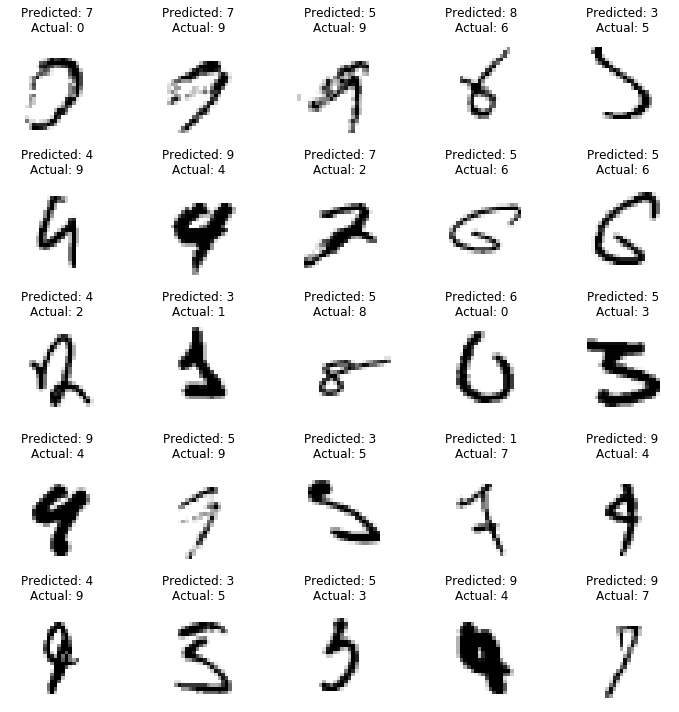

In [31]:
# with l1
plot_misclassified_images(misclassified_imgs_l1, "misclassified_imgs_l1.png")

### With L2 Regularization

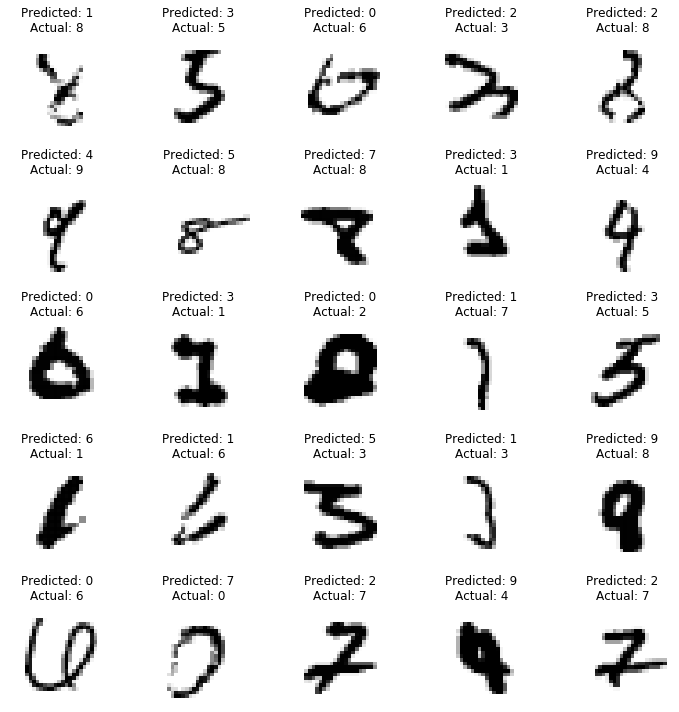

In [32]:
# wiith l2
plot_misclassified_images(misclassified_imgs_l2, "misclassified_imgs_l2.png")

# Plotting Metrics

In [0]:
def plot_graph(without, l1, l2,  both, metric):
    fig = plt.figure(figsize=(10, 10))
    
    plt.title(f'Validation %s' % (metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    without_plt, = plt.plot(without)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    both_plt, = plt.plot(both)
    
    plt.legend((without_plt, l1_plt, l2_plt, both_plt),
               ('Plain', 'L1', 'L2', 'L1 + L2'))

    fig.savefig(f'val_%s_change.png' % (metric.lower()))

### Validation Loss

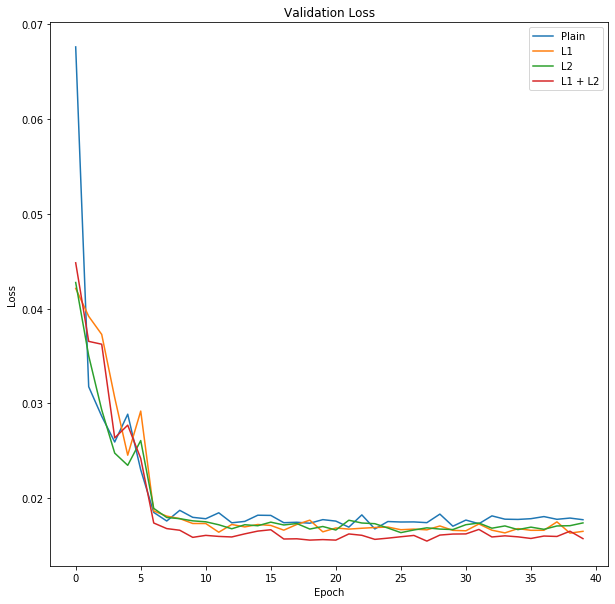

In [39]:
plot_graph(test_losses, test_losses_l1, test_losses_l2, test_losses_l12, "Loss")

### Validation Accuracy

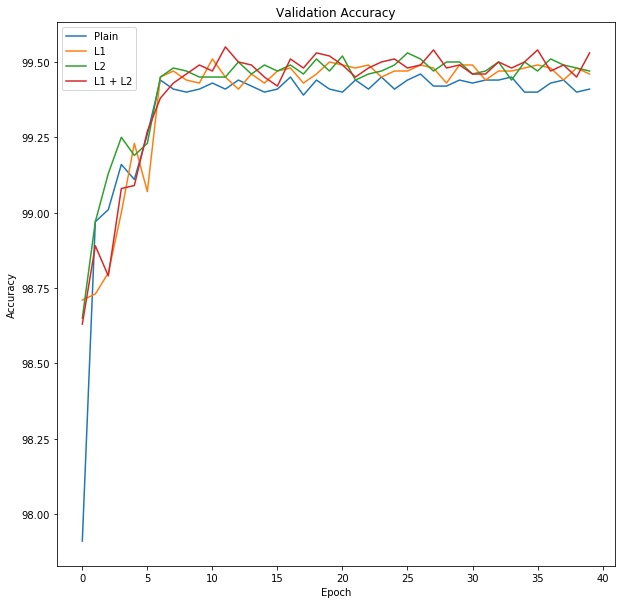

In [38]:
plot_graph(test_acc, test_acc_l1, test_acc_l2, test_acc_l12, "Accuracy")